In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# make sure the project root is accessible
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
print("✅ Project root added:", project_root)

# now import your project modules
from scripts.comparisonscript import default_parameters_for
from scripts.randomInstance import generate_instance
from evcs.model import build_base_model
from evcs.methods import build_initial_solution, local_search, evaluate_solution, compute_farther
from evcs.geom import build_arcs
from evcs.solve import solve_model
import contextlib, sys, io

@contextlib.contextmanager
def quiet():
    """Temporarily suppress stdout (solver logs, prints, etc.)"""
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout


✅ Project root added: c:\Users\asus\OneDrive\EV-projects\evcs-projects


In [3]:
# Utility: suppress console output from Pyomo / solver to keep plots clean
import contextlib, sys, io

@contextlib.contextmanager
def quiet():
    """Temporarily suppress stdout (for solver and Pyomo logs)."""
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout



→ Added 'closest_only' constraints.
→ Added 'closest_only' constraints.
✅ Greedy initialized with 4 stations (closest_only).


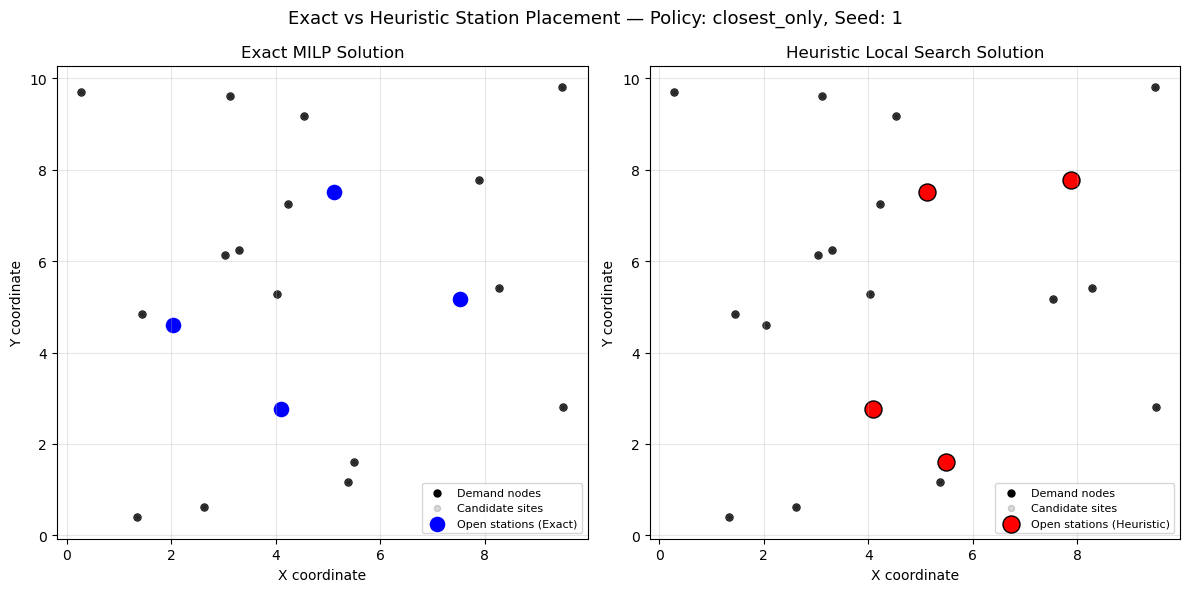

✅ Greedy initialized with 4 stations (closest_priority).


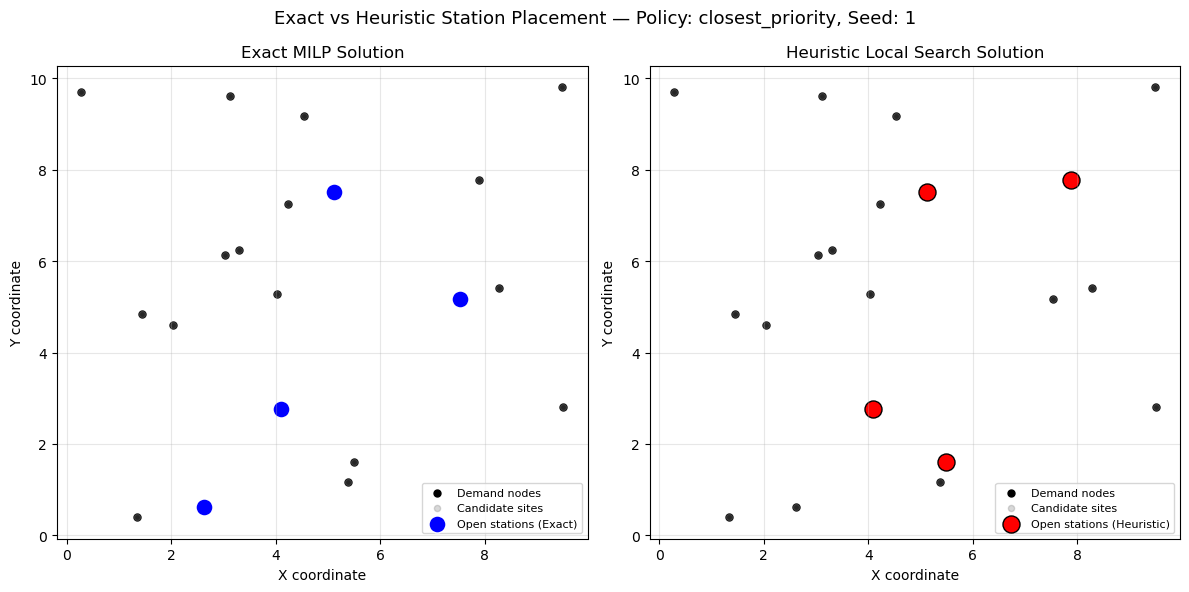

✅ Greedy initialized with 4 stations (system_optimum).


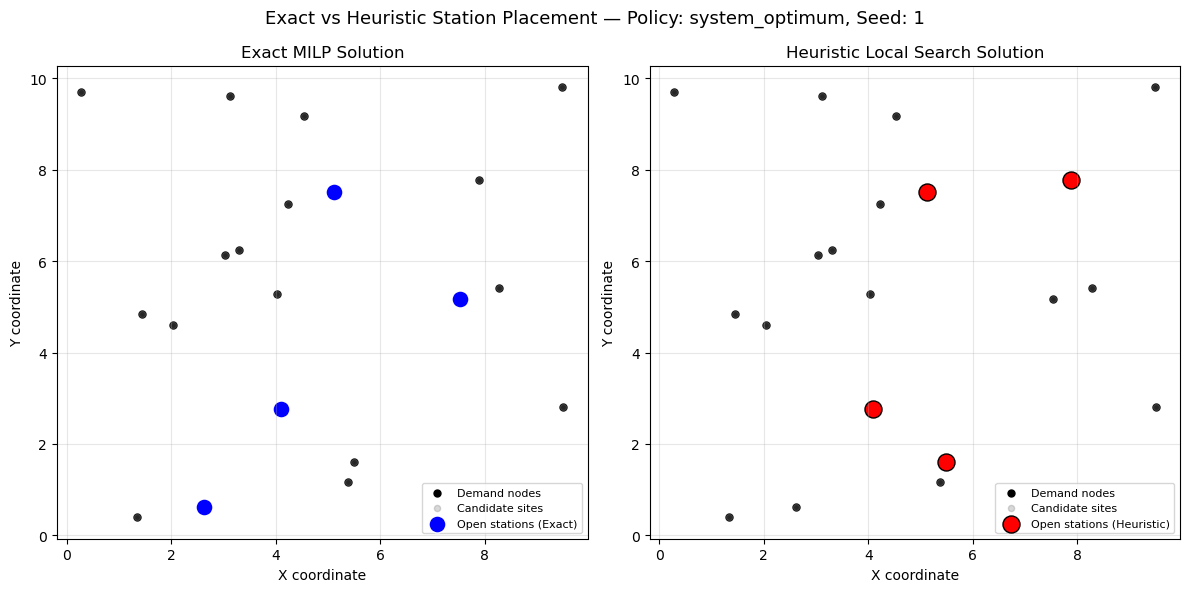

→ Added 'uniform' equal-split constraints.
→ Added 'uniform' equal-split constraints.
✅ Greedy initialized with 4 stations (uniform).


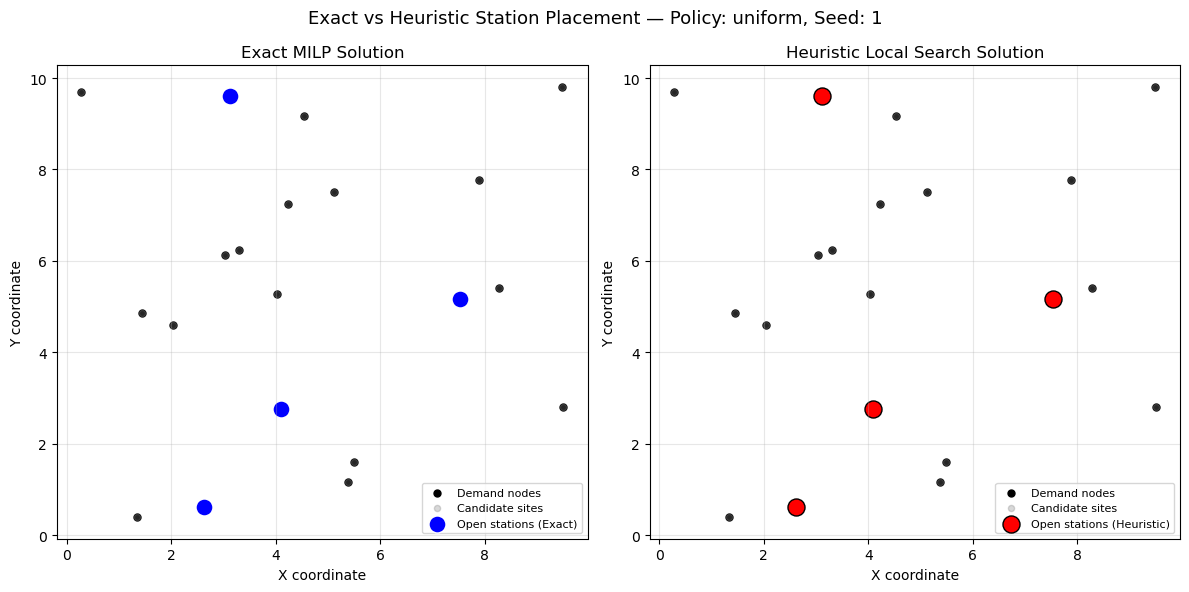

→ Added 'closest_only' constraints.
→ Added 'closest_only' constraints.
✅ Greedy initialized with 5 stations (closest_only).


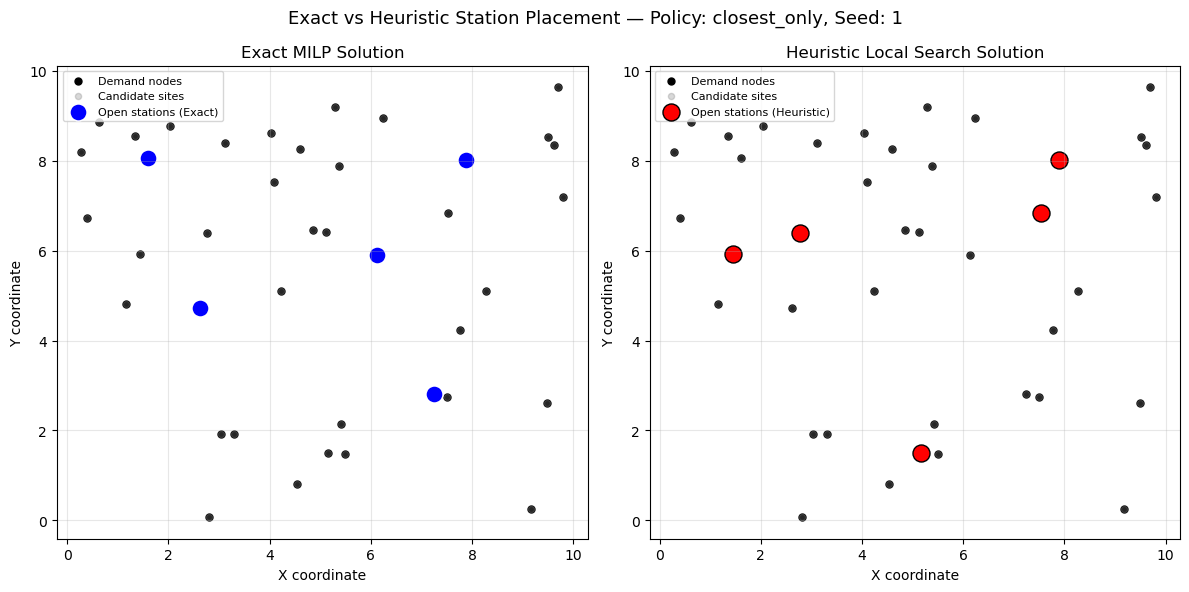

✅ Greedy initialized with 5 stations (closest_priority).


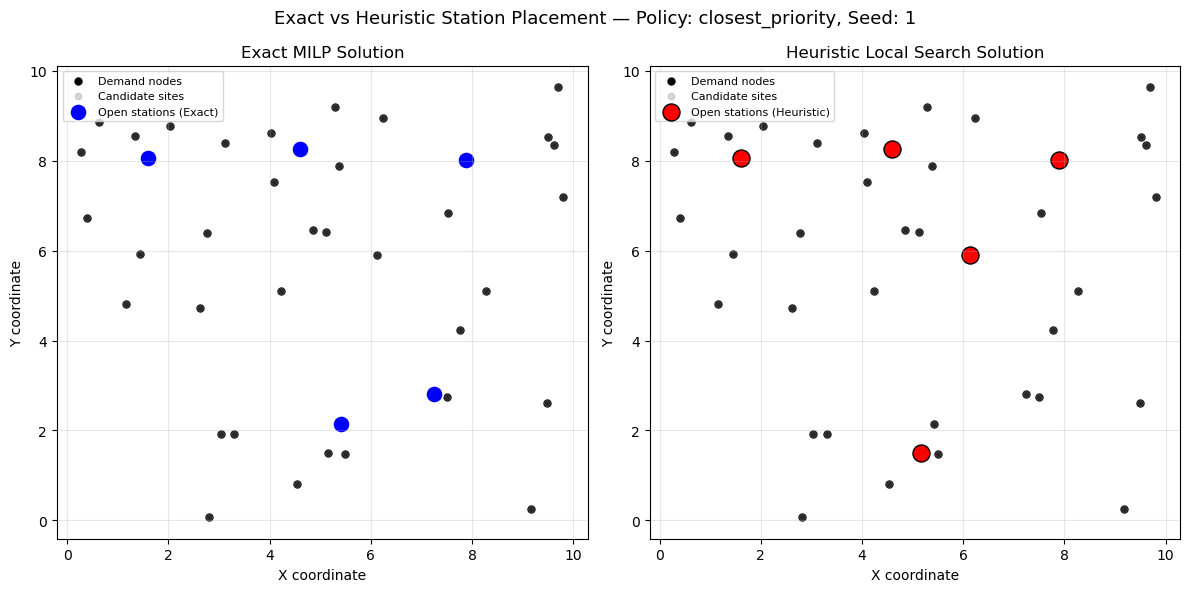

✅ Greedy initialized with 5 stations (system_optimum).


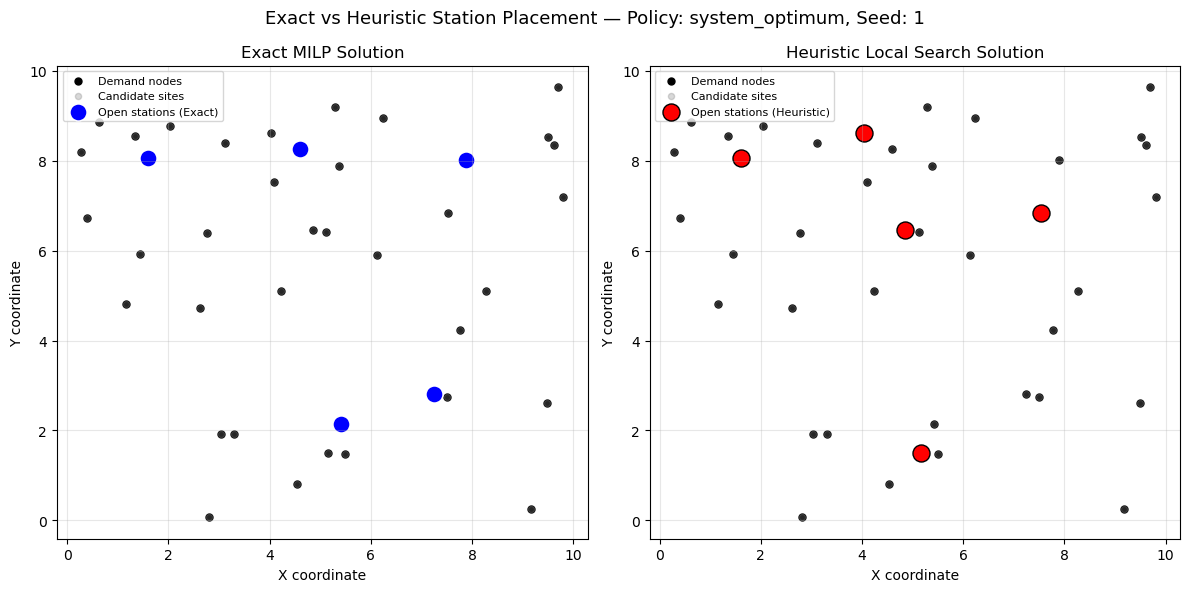

→ Added 'uniform' equal-split constraints.
→ Added 'uniform' equal-split constraints.
✅ Greedy initialized with 5 stations (uniform).


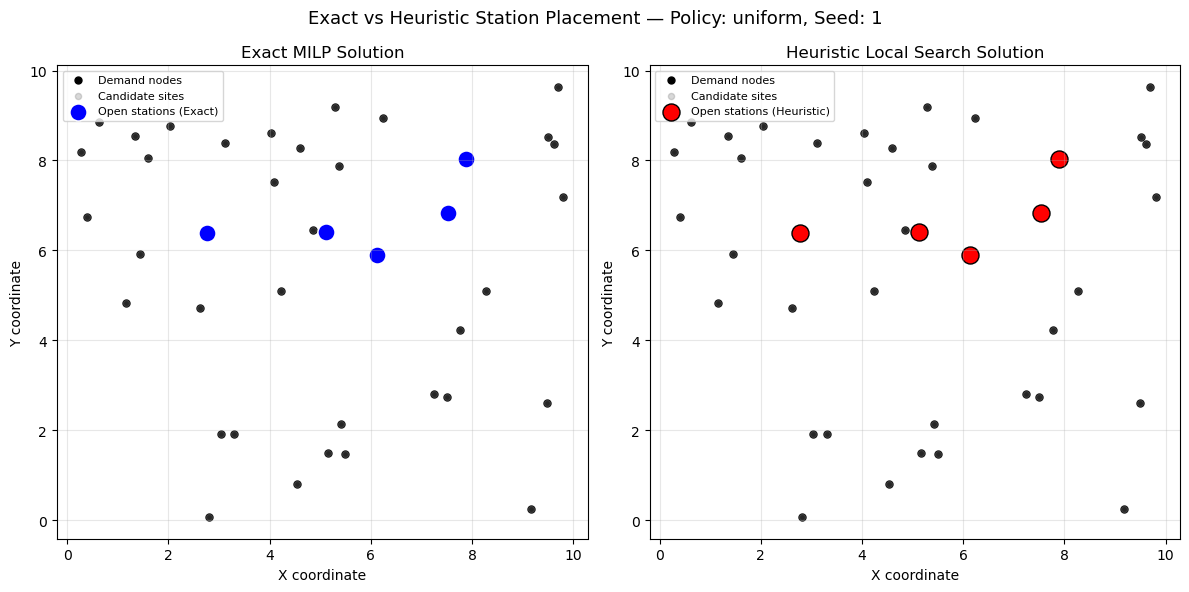

→ Added 'closest_only' constraints.
→ Added 'closest_only' constraints.
✅ Greedy initialized with 6 stations (closest_only).


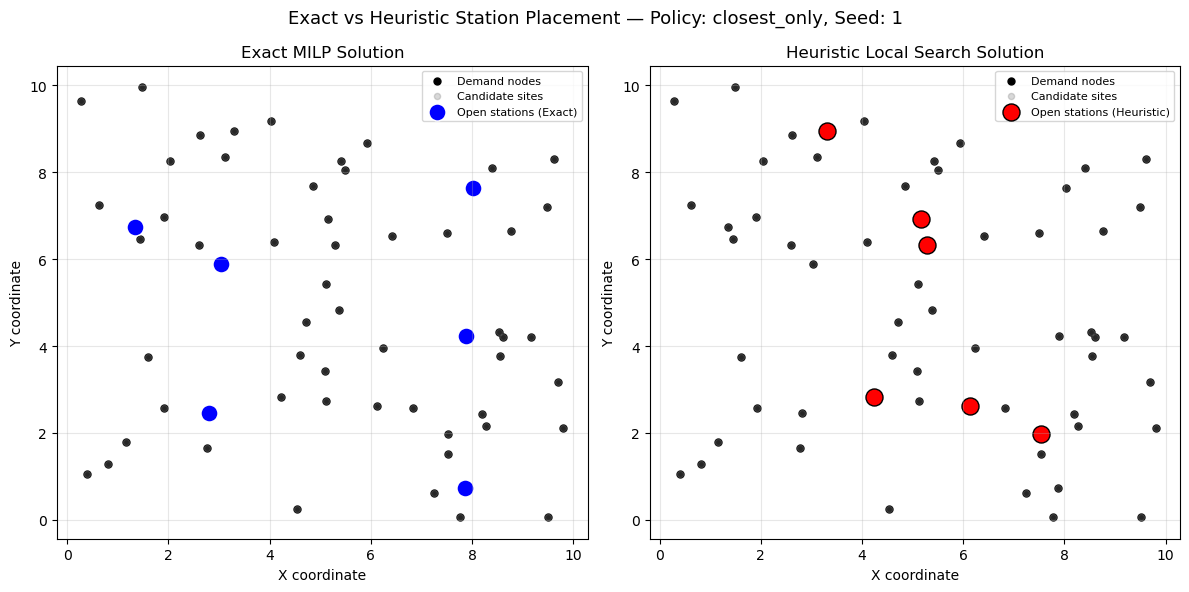

✅ Greedy initialized with 6 stations (closest_priority).


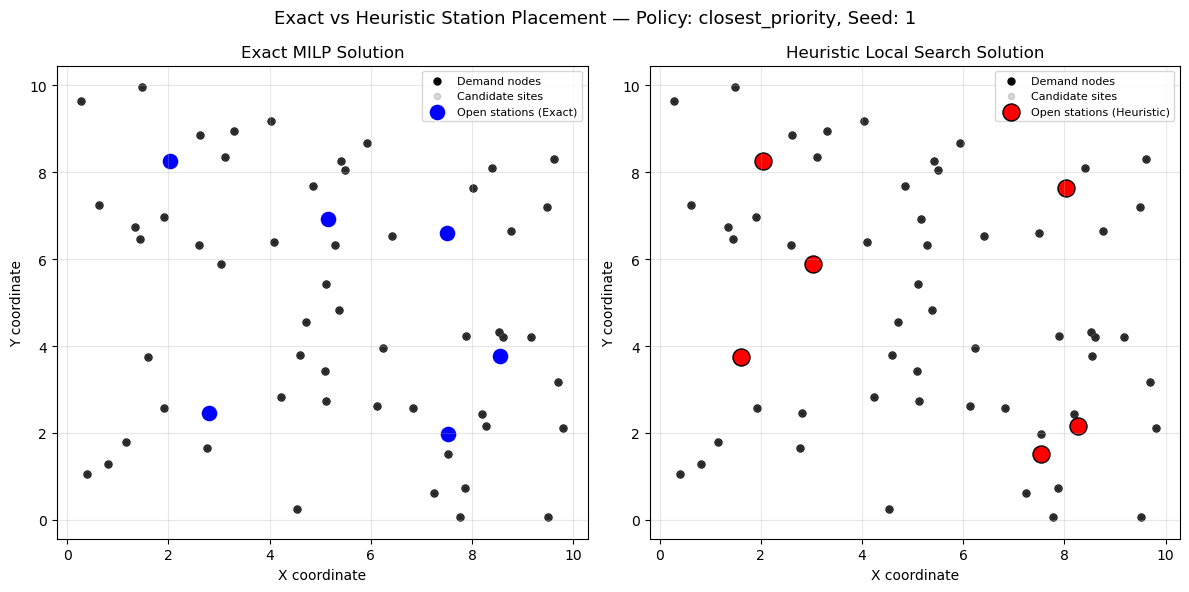

✅ Greedy initialized with 6 stations (system_optimum).


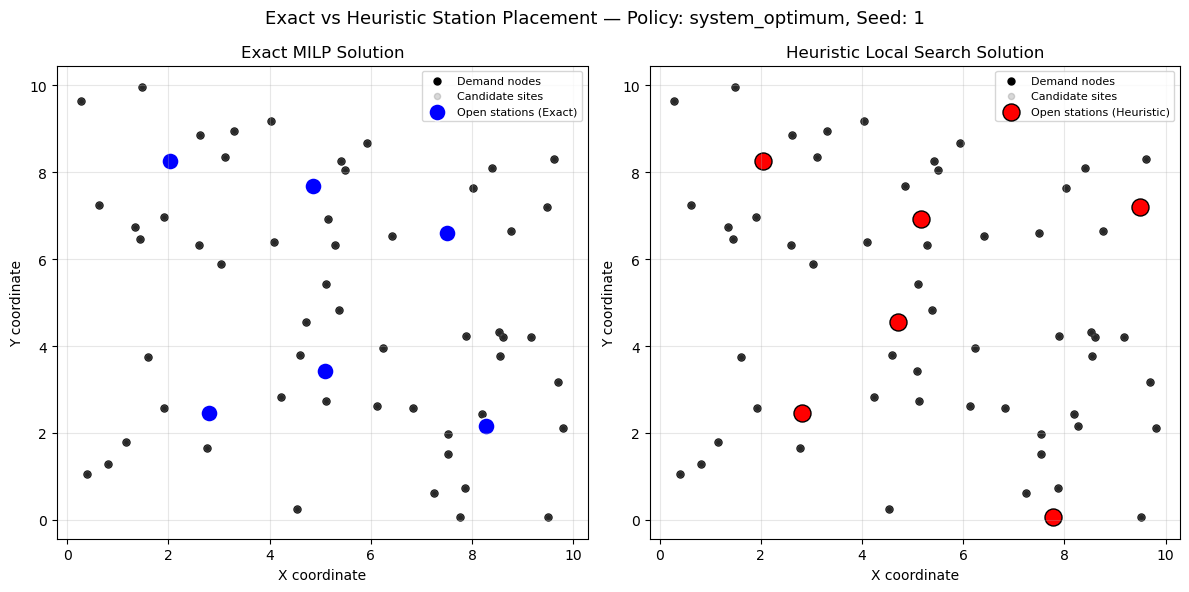

→ Added 'uniform' equal-split constraints.
→ Added 'uniform' equal-split constraints.
✅ Greedy initialized with 6 stations (uniform).


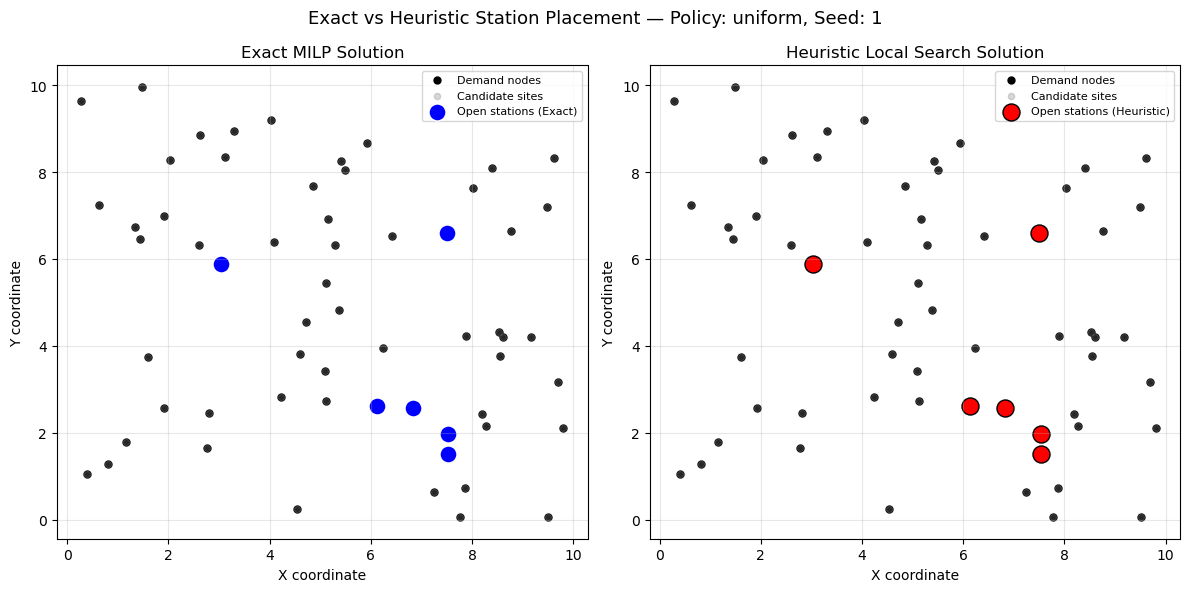

In [4]:
def plot_exact_vs_heuristic(inst, m_exact, m_heur, policy="", seed=None):
    """
    Plot side-by-side comparison of exact vs heuristic station placements.
    Shows:
      - Demand nodes (black dots)
      - Candidate stations (gray faint points)
      - Open stations (Exact = blue, Heuristic = red)
      - Optional seed and policy labels
    """
    coords_I = np.array(inst["coords_I"])
    coords_J = np.array(inst["coords_J"])

    # Extract which stations are open
    open_exact = [j for j in m_exact.J if (m_exact.x[j].value or 0.0) > 0.5]
    open_heur  = [j for j in m_heur.J  if (m_heur.x[j].value or 0.0) > 0.5]

    # --- Create figure ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left: Exact solution
    ax = axes[0]
    ax.scatter(coords_I[:,0], coords_I[:,1], c="black", s=25, label="Demand nodes")
    ax.scatter(coords_J[:,0], coords_J[:,1], c="gray", s=20, alpha=0.3, label="Candidate sites")
    ax.scatter(coords_J[open_exact,0], coords_J[open_exact,1],
               c="blue", s=150, edgecolors="white", label="Open stations (Exact)")
    ax.set_title("Exact MILP Solution")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

    # Right: Heuristic solution
    ax = axes[1]
    ax.scatter(coords_I[:,0], coords_I[:,1], c="black", s=25, label="Demand nodes")
    ax.scatter(coords_J[:,0], coords_J[:,1], c="gray", s=20, alpha=0.3, label="Candidate sites")
    ax.scatter(coords_J[open_heur,0], coords_J[open_heur,1],
               c="red", s=150, edgecolors="black", label="Open stations (Heuristic)")
    ax.set_title("Heuristic Local Search Solution")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

    for ax in axes:
        ax.set_xlabel("X coordinate")
        ax.set_ylabel("Y coordinate")

    title = "Exact vs Heuristic Station Placement"
    if policy:
        title += f" — Policy: {policy}"
    if seed is not None:
        title += f", Seed: {seed}"
    plt.suptitle(title, fontsize=13)
    plt.tight_layout()
    plt.show()


# ============================================================
# 🧠 Visualization Loop (No Text Output, Only Plots)
# ============================================================
from scripts.randomInstance import generate_instance
from scripts.comparisonscript import default_parameters_for
from evcs.model import build_base_model
from evcs.methods import build_initial_solution, local_search, compute_farther
from evcs.geom import build_arcs
from evcs.solve import solve_model

policies = ["closest_only", "closest_priority", "system_optimum", "uniform"]
seeds = [1,]
Ns = [20, 40, 60]   # 👈 list of different instance sizes


for N in Ns:                      # 👈 loop over each N
    for policy in policies:
        for seed in seeds:
            # --- Instance setup ---
            inst = generate_instance(N=N, seed=seed)
            P, Q, D = default_parameters_for(N)
        coords_I, coords_J = inst["coords_I"], inst["coords_J"]
        I_idx, J_idx = inst["I_idx"], inst["J_idx"]
        demand_I = inst["demand_I"]

        # --- Build arcs and model structures ---
        distIJ, in_range, Ji, Ij = build_arcs(coords_I, coords_J, D=D, I_idx=I_idx, J_idx=J_idx)
        farther_of = compute_farther(distIJ, in_range, Ji)

        # --- Solve exact model quietly ---
        m_exact = build_base_model(len(I_idx), len(J_idx),
                                   in_range, Ji, Ij,
                                   demand_I, Q, P,
                                   distIJ, method_name=policy)
        with quiet():
            solve_model(m_exact)

        # --- Build heuristic quietly ---
        m_greedy = build_base_model(len(I_idx), len(J_idx),
                                    in_range, Ji, Ij,
                                    demand_I, Q, P,
                                    distIJ, method_name=policy)
        m_greedy = build_initial_solution(m_greedy, distIJ, mode="greedy", policy=policy)
        with quiet():
            m_heur = local_search(m_greedy, distIJ, in_range, Ji, Ij,
                                  farther_of, method_name=policy, max_iter=50)

        # --- Plot only ---
        plot_exact_vs_heuristic(inst, m_exact, m_heur, policy=policy, seed=seed)